# How do starspot contrasts vary with stellar effective temperature in the Gaia $G$ bandpass?

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
import astropy.units as u

from astropy.modeling.blackbody import blackbody_lambda

Use starspot properties from Table 5 of [Berdyugina 2005](http://adsabs.harvard.edu/abs/2005LRSP....2....8B): 

In [64]:
table5 = ascii.read('berdyugina2005.csv')

*Approximate* the $G$ band transmittance curve from Figure 3 of [Jordi et al. 2010](https://arxiv.org/abs/1008.0815):

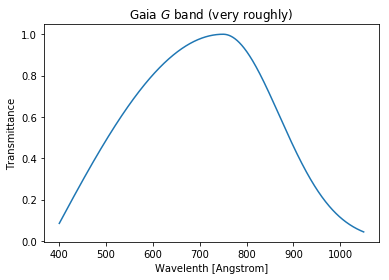

In [65]:
lam = np.linspace(400, 1050, 1000)*u.nm
filt = np.cos(((lam - 750*u.nm)/(150*u.nm)).value * 2/np.pi)
cond = lam > 750*u.nm
filt[cond] = np.exp(-0.5 * (lam[cond] - 750*u.nm)**2/(120*u.nm)**2)

plt.plot(lam, filt)
plt.gca().set(xlabel='Wavelenth [Angstrom]', ylabel='Transmittance', 
             title='Gaia $G$ band (very roughly)')
plt.show()

Plot the spot and photosphere temperatures, along with the spot contrasts integrated in the Gaia bandpass. 

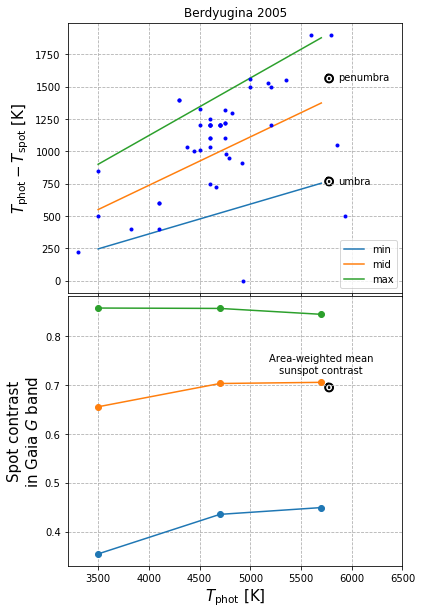

In [84]:
fontsize = 15

temp_phots = [3500, 4700, 5700]
temp_diffs = [[200, 770], [550, 1400], [900, 1900]]
tphots = [[3300, 5770], [3500, 5770], [3500, 5750]]
labels = ['min', 'mid', 'max']
fig, ax = plt.subplots(2, 1, figsize=(6, 10), sharex=True)

for temp_diff, tphot, lab in zip(temp_diffs, tphots, labels):

    fit = np.polyfit(tphot, temp_diff, 1)
    get_temp_diff = lambda temp_phot: np.polyval(fit, temp_phot)
    ax[0].plot(temp_phots, get_temp_diff(temp_phots), label=lab)

    contrasts = []
    for temp in temp_phots: 
        phot_irr = blackbody_lambda(lam, temp)
        spot_temp = temp - get_temp_diff(temp)
        spot_irr = blackbody_lambda(lam, spot_temp)

        contrast = 1 - np.trapz(spot_irr*filt) / np.trapz(phot_irr*filt)
        contrasts.append(contrast)

    ax[1].plot(temp_phots, contrasts, 'o-')
    
ax[0].legend(loc='lower right')
ax[0].plot(table5['Teff K'], table5['deltaT K'], 'b.')

sunspot_contrasts = []

for temp_diff, temp_phot, l in zip([5770-5000, 5770-4200], 
                                   [5770, 5770],
                                   ['umbra', 'penumbra']):
    ax[0].scatter(temp_phot, temp_diff, color='k', marker='$\odot$', 
                  label='sun', s=100)
    ax[0].annotate(l, xy=(temp_phot+100, temp_diff), 
                   va='center', color='k')

    phot_irr = blackbody_lambda(lam, temp_phot)
    spot_temp = temp_phot - temp_diff
    spot_irr = blackbody_lambda(lam, spot_temp)

    contrast = 1 - np.trapz(spot_irr*filt) / np.trapz(phot_irr*filt)
    sunspot_contrasts.append(contrast.value)

area_weighted_sunspot_contrast = np.dot(sunspot_contrasts, [1/5, 4/5])

ax[1].set_ylabel('Spot contrast\nin Gaia $G$ band', fontsize=fontsize)
ax[1].set_xlabel("$T_{\mathrm{phot}}$ [K]", fontsize=fontsize)
ax[0].set_ylabel("$T_{\mathrm{phot}} - T_{\mathrm{spot}}$ [K]", 
                 fontsize=fontsize)
ax[0].set_title('Berdyugina 2005')
ax[0].set_xlim([3200, 6500])

ax[1].scatter(5770, area_weighted_sunspot_contrast, color='k', marker='$\odot$', 
              label='sun', s=100)
ax[1].annotate("Area-weighted mean\nsunspot contrast", xy=(5700, 0.72), 
               va='bottom', ha='center', color='k')

for axis in ax:
    axis.grid(ls='--')

fig.subplots_adjust(hspace=0.01)
fig.savefig('contrasts.pdf', bbox_inches='tight')

*Upper*: The spot temperature contrasts scale roughly linearly with photosphere effective temperatures. Sunspot umbra and penumbra are marked with $\odot$.

*Lower*: Spot flux contrasts, approximated by integrating blackbody radiance curves with the temperatures of the photosphere and spot, convolved with the Gaia $G$ bandpass. The area-weighted mean sunspot contrast is 0.7, marked with $\odot$. 